<a href="https://colab.research.google.com/github/joseluisnaranjo/jolunavi/blob/master/Lab_Artificial_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijin University Of Science and Technology
神经网络与深度学习.

题目：    深度学习实验报告     .              
姓名：NARANJO VILLOTA JOSE LUIS     
学号：	    B20200692          .        
专业：   计算机科学与技术      .   
学院：   计算机与通信工程       


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


# Utility Functions

These are the plotting helper functions used further down in the notebook. You don't need to fully understand what's going on here to get the big picture. The names of the functions are self-explanatory. I would at first recommend to skip this part and proceed to the next Logistic Regression section.

In [ ]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)
    

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Loss")
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")

    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

# Logistic Regression

Despite its name, logistic regression (LR) is a binary *classification* algorithm. It's the most popular technique for 0/1 classification. LR will try to draw a straight line to separate the classes, that's where the term *linear model* comes from. LR works on arbitrary dimensions, not just two. For 3 dimensional data it'll try to draw a 2 dimensional plane to separate the classes. This generalizes to N dimensional data and N-1 dimensional hyperplane separator. If you have a supervised binary classification problem, given an input data with multiple columns and a binary 0/1 outcome, LR is the first method to try. In this section we will focus on 2 dimensional data since it's easier to visualize, and in the later sections we will work with multidimensional input.

## Linearly Separable Data

First let's start with the easy example. 2 dimensional linearly separable data. We are using the scikit-learn *make_classification* method to generate our data and use our helper function defined above to visualize it.

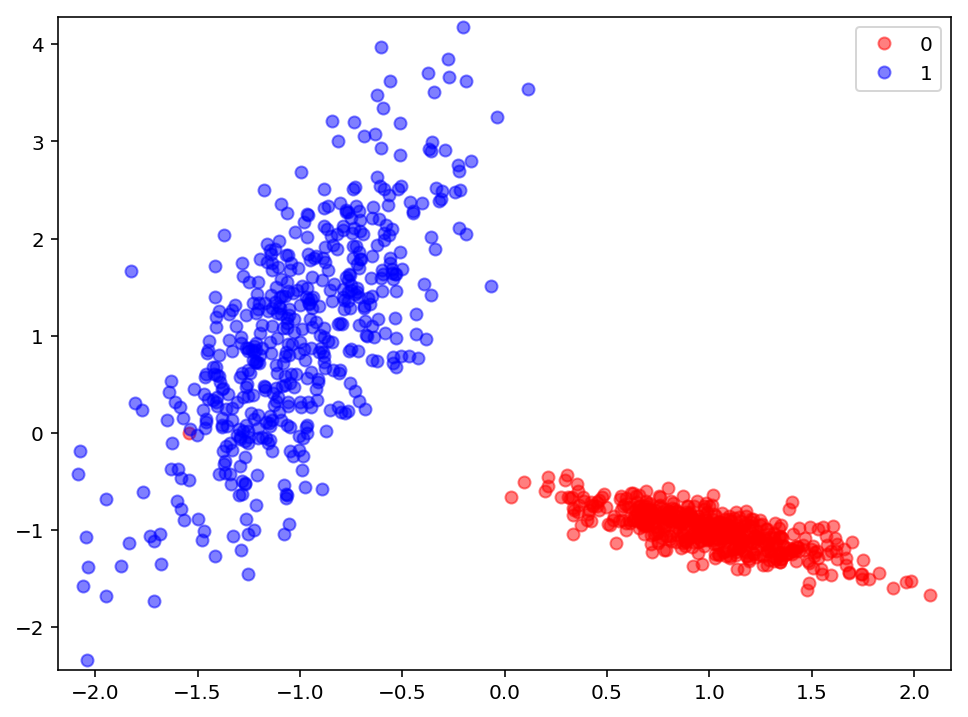

In [ ]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                           n_informative=2, random_state=7, n_clusters_per_class=1)
plot_data(X, y)

There is a *LogisticRegression* classifier available in scikit-learn, I won't go into too much detail here since our goal is to learn building models with Keras. But here's how to train an LR model, using the *fit* function just like any other model in scikit-learn. We see the linear decision boundary as the green line.

LR coefficients: [[-4.07231906  2.09044633]]
LR intercept: [-0.23103502]


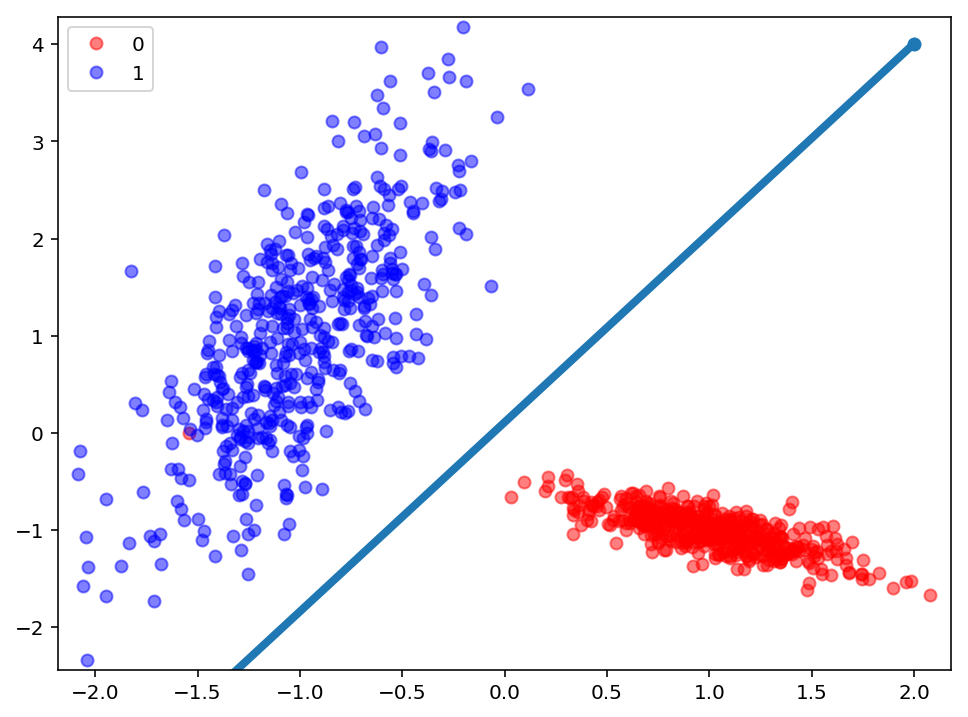

In [ ]:
lr = LogisticRegression()
lr.fit(X, y)
print('LR coefficients:', lr.coef_)
print('LR intercept:', lr.intercept_)

plot_data(X, y)

limits = np.array([-2, 2])
boundary = -(lr.coef_[0][0] * limits + lr.intercept_[0]) / lr.coef_[0][1]
plt.plot(limits, boundary, "o-", linewidth=4)




<Figure size 576x432 with 0 Axes>

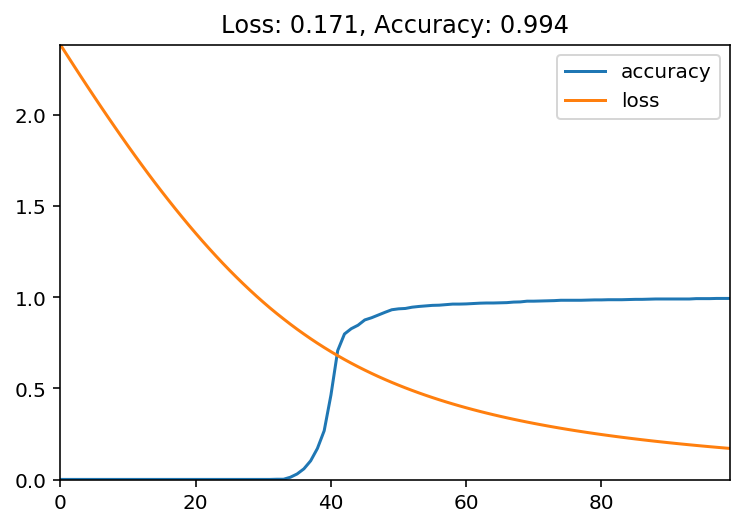

In [ ]:
model = Sequential()
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x=X, y=y, verbose=0, epochs=100)
plot_loss_accuracy(history)

A fancy plot of the decision boundary. The various shades of blue and red represent the probability of a hypothetical point in that area belonging to class 1. The top left area is classified as class 1, so the dark blue. The bottom right area is classified as class 0, so the dark red. And there is a transition around the decision boundary. I think this is a cool way to visualize the separator function the model is learning.

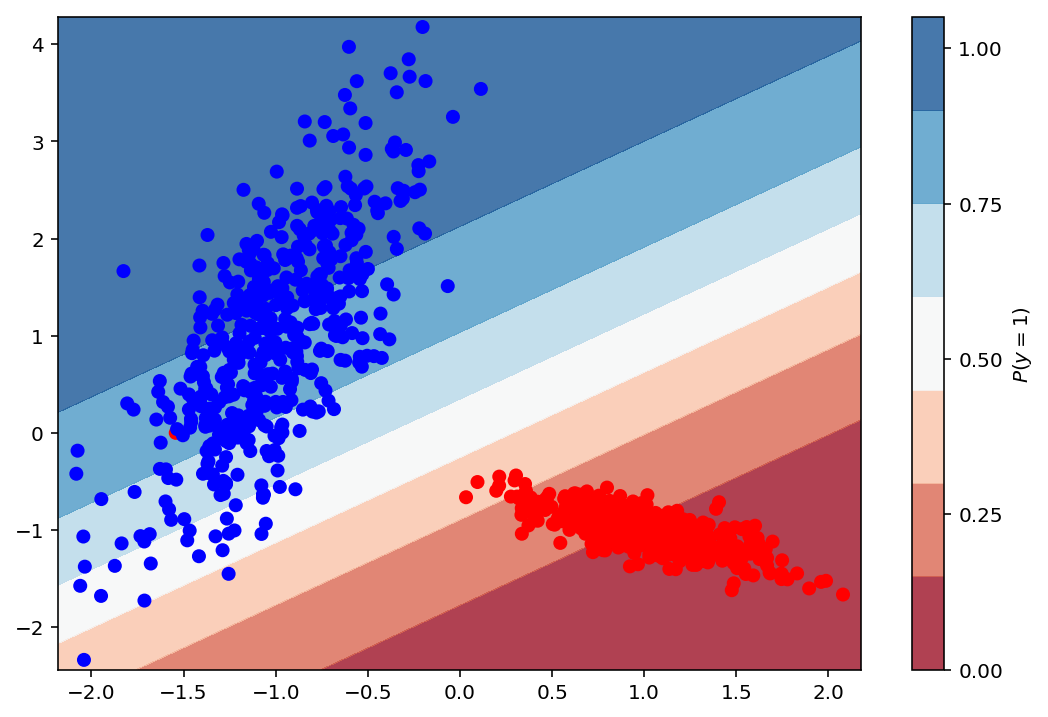

In [ ]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

The classification report showing the precision and recall of our model.

In [ ]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       501
           1       1.00      1.00      1.00       499

   micro avg       1.00      1.00      1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



The confusion matrix shows us how many classes were correctly classified vs misclassified. The numbers on the diagonal axis represent the number of correctly classified points, the rest are the misclassified ones. This particular matrix is not very interesting because the model correctly predicts the class of all but one point. We can see the misclassified point at the top right part of the confusion matrix, true value is class 0 but the predicted value is class 1.

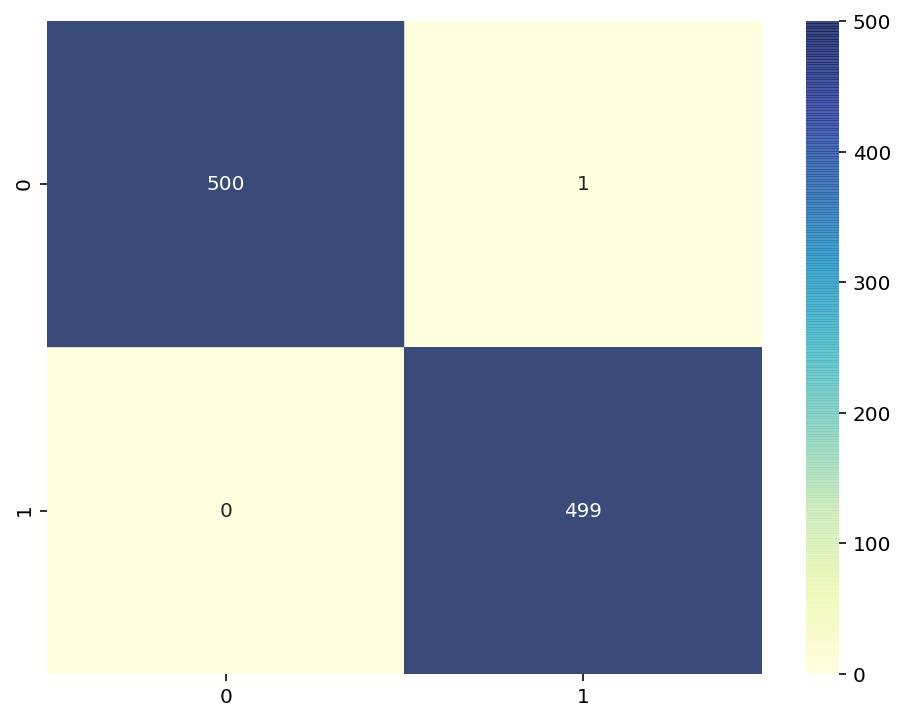

In [ ]:
plot_confusion_matrix(model, X, y)

## Complex Data - Moons

The previous dataset was linearly separable, so it was trivial for our logistic regression model to separate the classes. Here is a more complex dataset which isn't linearly separable. The simple logistic regression model won't be able to distinguish between the classes.

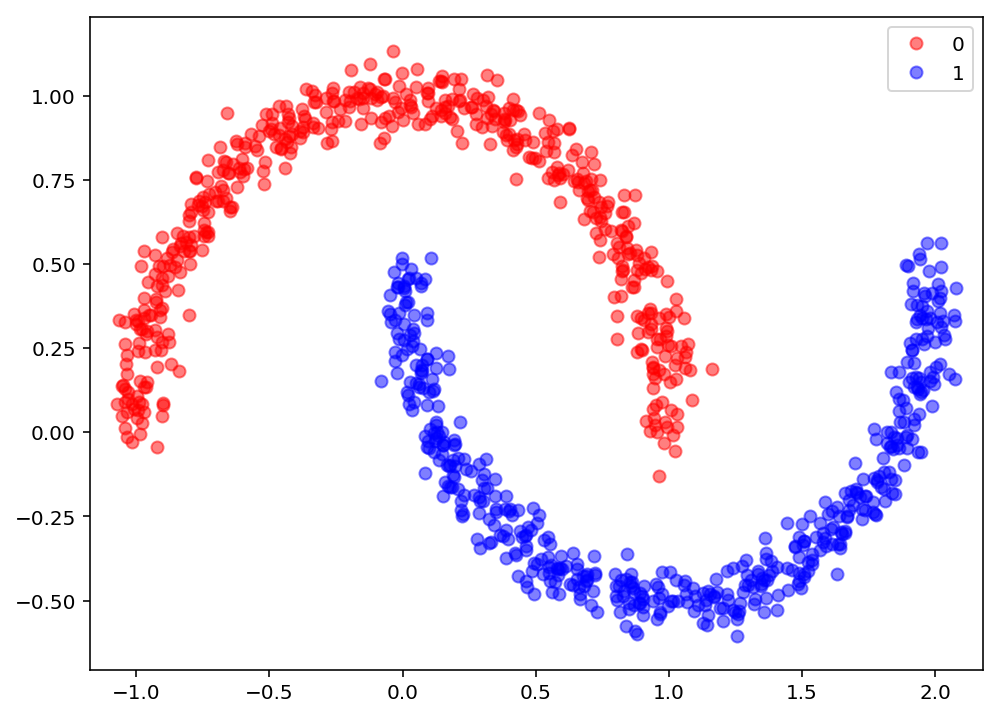

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
plot_data(X,y)

We're building the another logistic regression model with the same parameters as we did before.

<Figure size 576x432 with 0 Axes>

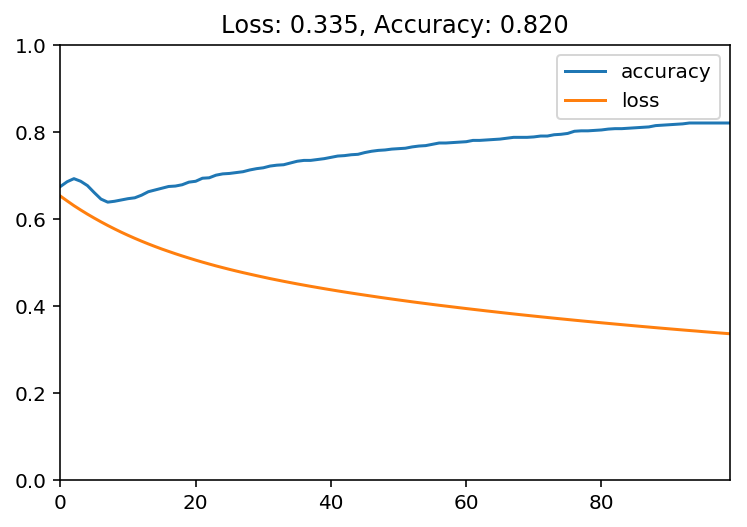

In [ ]:
model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)
plot_loss_accuracy(history)

The current decision boundary doesn't look as clean as the one before. The model tried to separate out the classes from the middle, but there are a lot of misclassified points. We need a more complex classifier with a non-linear decision boundary, and we will see an example of that soon.

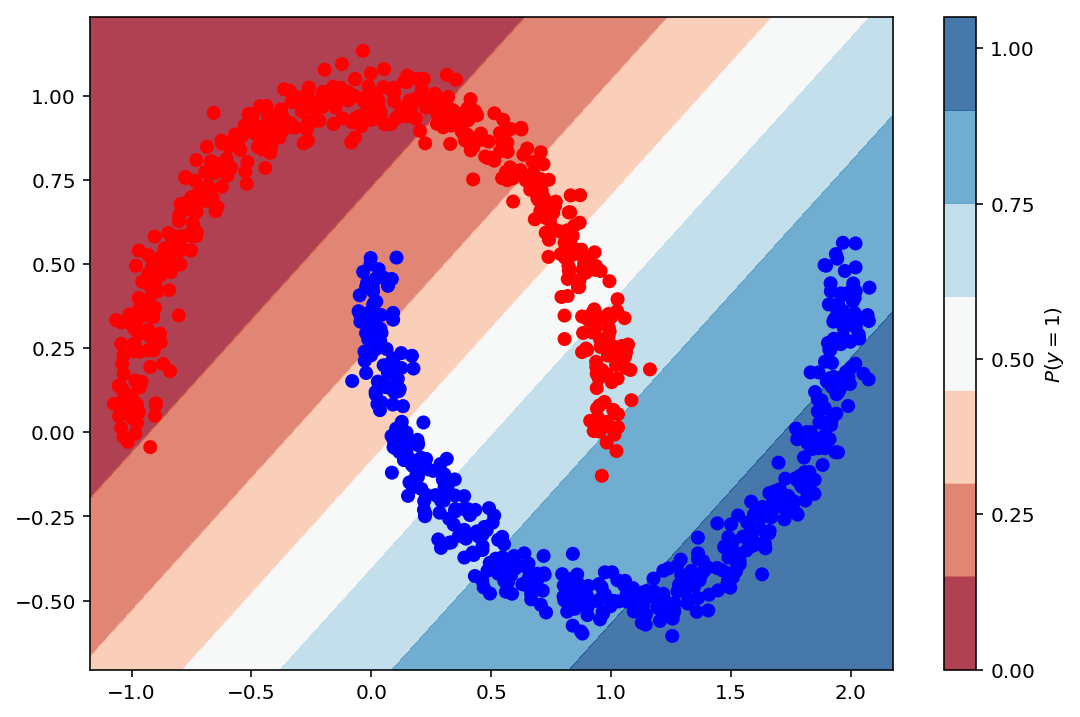

In [ ]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

Precision of the model is 86%. It looks good on paper but we should be able to get 100% with a more complex model. You can imagine a curved decision boundary that will separate out the classes, and a complex model should be able to approximate that.

             precision    recall  f1-score   support

          0       0.86      0.87      0.86       500
          1       0.87      0.86      0.86       500

avg / total       0.86      0.86      0.86      1000



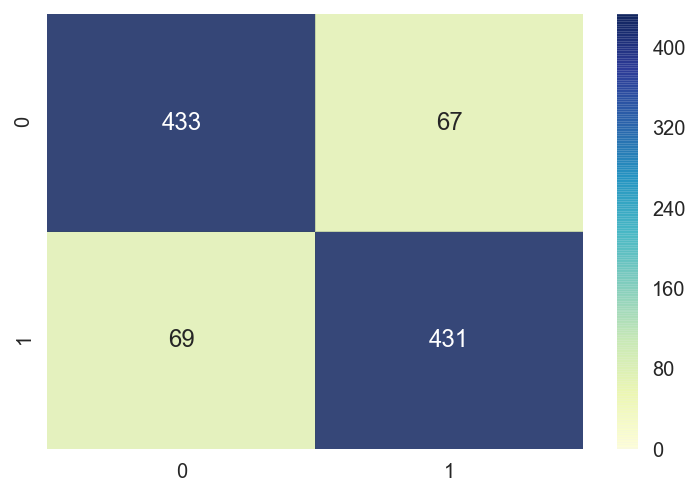

In [ ]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

## Complex Data - Circles

Let's look at one final example where the liner model will fail.

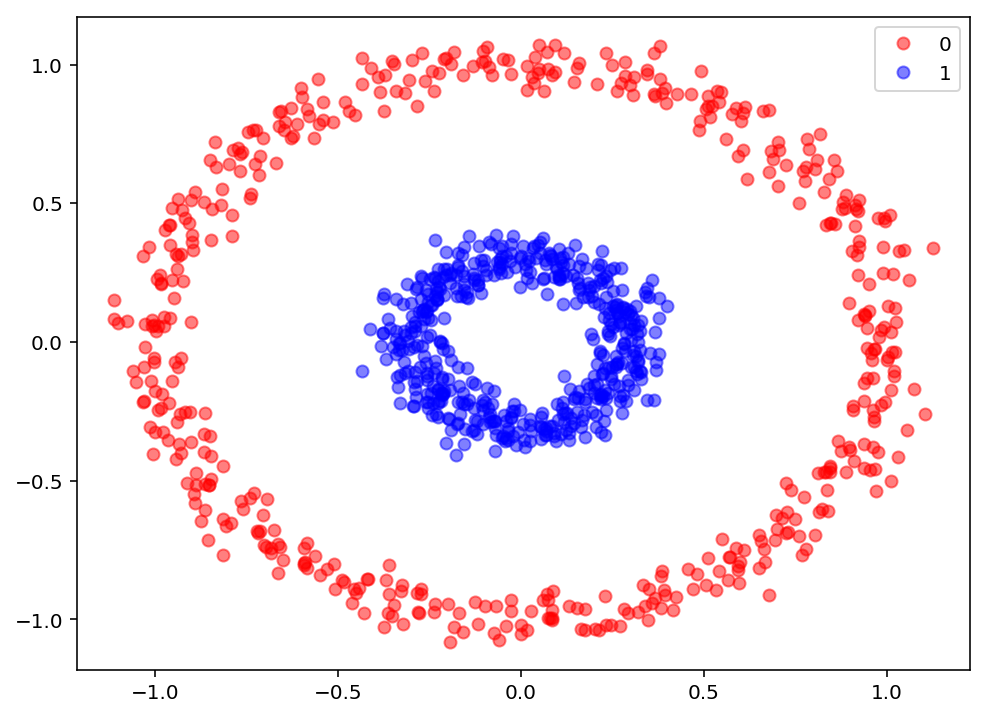

In [ ]:
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)
plot_data(X, y)

Building the model with same parameters.

<Figure size 576x432 with 0 Axes>

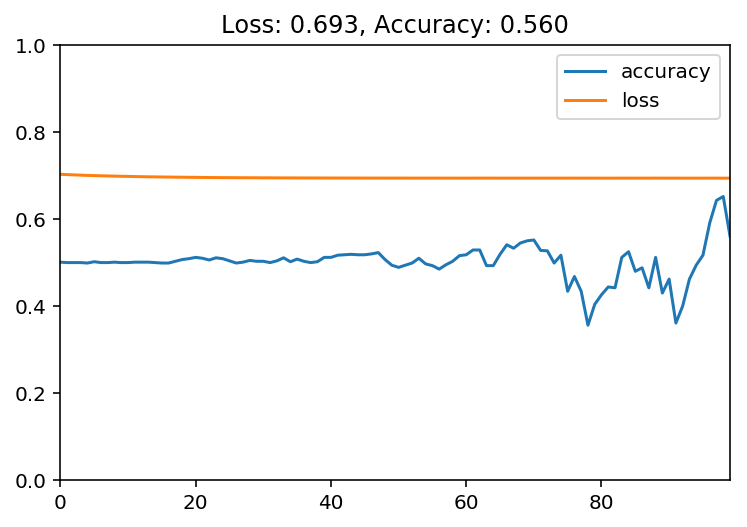

In [ ]:
model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)
plot_loss_accuracy(history)

The decision boundary again passes from the middle of the data, but now we have much more misclassified points.

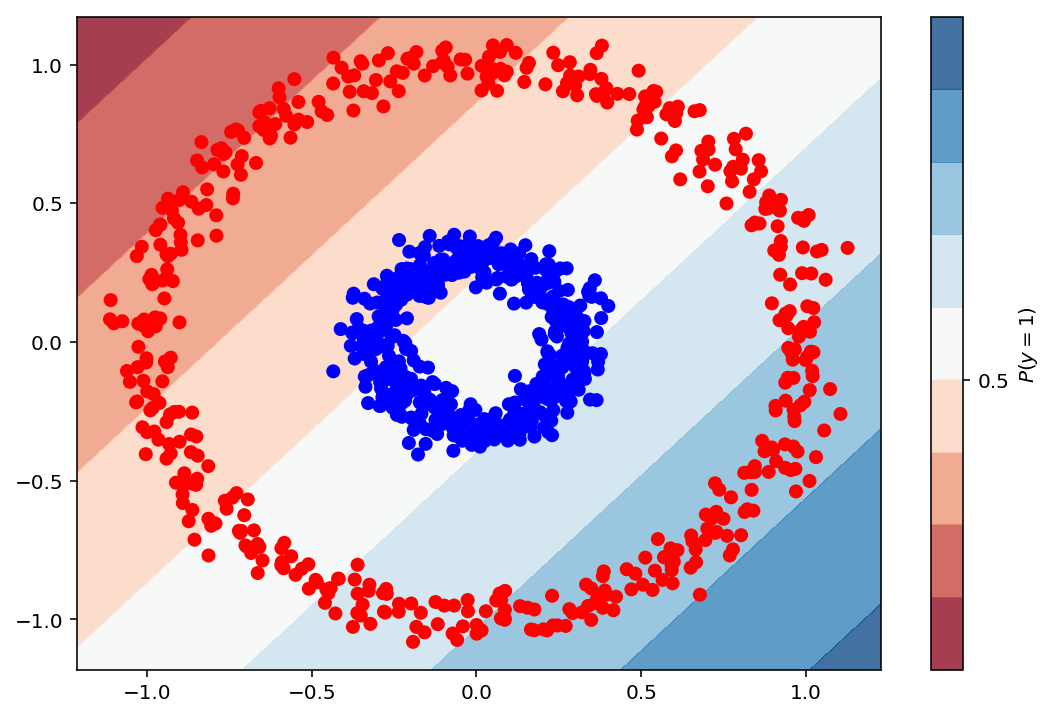

In [ ]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

The accuracy is 51%. No matter where the model draws the linear line, it will misclassify half of the points, due to the nature of the dataset.

The confusion matrix we see here is an example one belonging to a poor classifier. Ideally we want confusion matrices like the ones we saw above. High numbers along the diagonals meaning that the classifier was right, and low numbers everywhere else where the classifier was wrong. In our visualization, the color blue represents the high numbers and yellow represents the low ones. So we would prefer to see blue on the diagonals and yellow everywhere else, blues everywhere is a bad sign meaning that our classifier is confused.

              precision    recall  f1-score   support

           0       0.59      0.45      0.51       500
           1       0.56      0.69      0.61       500

   micro avg       0.57      0.57      0.57      1000
   macro avg       0.57      0.57      0.56      1000
weighted avg       0.57      0.57      0.56      1000



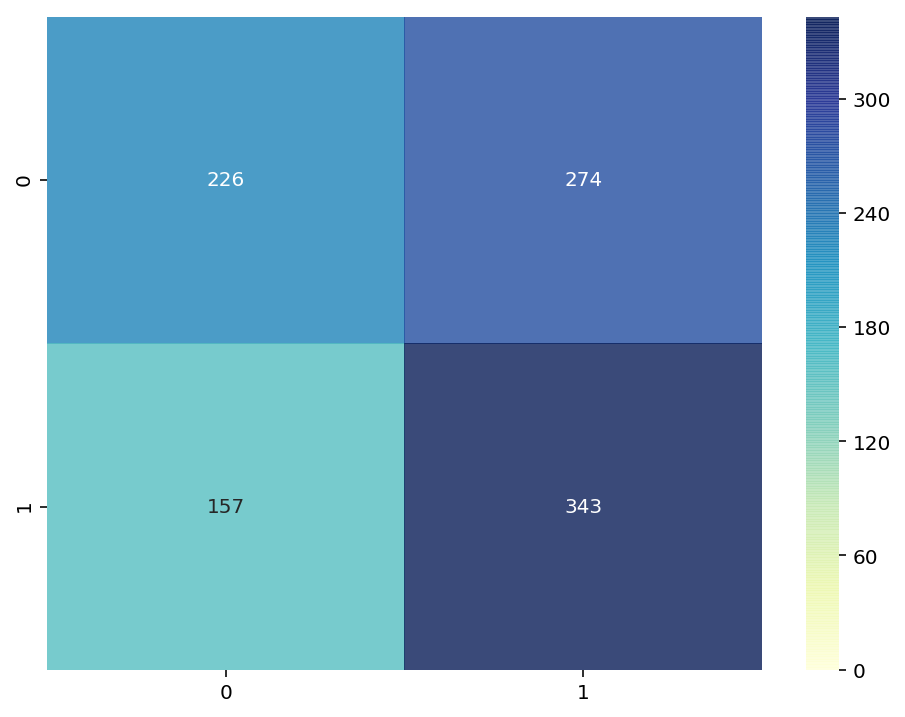

In [ ]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

Now we will train a deep Artificial Neural Network (ANN) to better classify the datasets which the logistic regression model struggled, Moons and Circles datasets. We will also classify an even harder dataset of Sine Wave to demonstrate that ANNs can form really complex decision boundaries.